<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li></ul></li><li><span><a href="#Predicción-de-Ozono-para-el-Valle-de-México" data-toc-modified-id="Predicción-de-Ozono-para-el-Valle-de-México-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predicción de Ozono para el Valle de México</a></span></li></ul></div>

In [1]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import altair as alt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet

from fbprophet import Prophet

pd.options.mode.chained_assignment = None

%matplotlib inline

# Init data

## Estaciones

In [2]:
estaciones = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [3]:
mediciones = pd.read_csv('/data/calidad_aire_presidencia/data_mediciones_todas_estaciones_2.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [4]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(123, 3)


,city,state,estacionesid
0,Durango,Durango,58
6543,Durango,Durango,59
33554,Durango,Durango,60
65683,Gómez Palacio,Durango,65
80484,Celaya,Guanajuato,68


In [5]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

In [49]:
estaciones_ciudad[estaciones_ciudad.city=='Valle de México'].merge(estaciones)

,city,state,estacionesid,_id,lat,long,nombre,codigo,redesid,date-insert
0,Valle de México,Ciudad de México,242,5b8850e3e2705c1932e8306b,19.272222,-99.207778,Ajusco Medio,AJM,119,2018-08-30 20:17:39.225
1,Valle de México,Ciudad de México,243,5b8850e3e2705c1932e8306c,19.577222,-99.254167,Atizapán,ATI,119,2018-08-30 20:17:39.225
2,Valle de México,Ciudad de México,244,5b8850e3e2705c1932e8306d,19.468611,-99.170000,Camarones,CAM,119,2018-08-30 20:17:39.225
3,Valle de México,Ciudad de México,245,5b8850e3e2705c1932e8306e,19.326389,-99.176111,Centro de Ciencias de la Atmósfera,CCA,119,2018-08-30 20:17:39.225
4,Valle de México,Ciudad de México,248,5b8850e3e2705c1932e83071,19.365556,-99.291944,Cuajimalpa,CUA,119,2018-08-30 20:17:39.225
5,Valle de México,Ciudad de México,250,5b8850e3e2705c1932e83073,19.482500,-99.243611,FES Acatlán,FAC,119,2018-08-30 20:17:39.225
6,Valle de México,Ciudad de México,251,5b8850e3e2705c1932e83074,19.411667,-99.152222,Hospital General de México,HGM,119,2018-08-30 20:17:39.225
7,Valle de México,Ciudad de México,253,5b8850e3e2705c1932e83076,19.535000,-99.117778,La Presa,LPR,119,2018-08-30 20:17:39.225
8,Valle de México,Ciudad de México,256,5b8850e3e2705c1932e83078,19.424722,-99.119722,Merced,MER,119,2018-08-30 20:17:39.225
9,Valle de México,Ciudad de México,257,5b8850e3e2705c1932e83079,19.460417,-98.902861,Montecillo,MON,119,2018-08-30 20:17:39.225


# Predicción de Ozono para el Valle de México

In [6]:
ciudad = mediciones[(mediciones.city.isin(['Valle de México']))]
ciudad['fecha_hora']  = pd.to_datetime(ciudad.fecha + ' ' +
                                            ciudad.hora.astype(str) +':00:00')

ciudad['fecha'] = pd.to_datetime(ciudad.fecha)

ciudad['dia_semana'] = ciudad.fecha.dt.weekday_name

O3_valleMex = ciudad[(ciudad.parametro.isin(['O3']))]

O3_valleMex = O3_valleMex.sort_values('fecha_hora')
print(O3_valleMex.shape)
O3_valleMex.head()

(152281, 10)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora,dia_semana
1891057,Valle de México,240,2018-01-01,0,O3,Ciudad de México,1,0.011,2018-01-01,Monday
2718294,Valle de México,301,2018-01-01,0,O3,Ciudad de México,1,0.038,2018-01-01,Monday
2052820,Valle de México,249,2018-01-01,0,O3,Ciudad de México,1,0.018,2018-01-01,Monday
2078440,Valle de México,250,2018-01-01,0,O3,Ciudad de México,1,0.026,2018-01-01,Monday
2104364,Valle de México,251,2018-01-01,0,O3,Ciudad de México,1,0.015,2018-01-01,Monday


In [50]:
# centro de ciencias de la atmósfera: 245
# Pedregal: 259
ts_estacion = O3_valleMex[O3_valleMex.estacionesid==245]

ntest = 12

ts_test = ts_estacion[-ntest::][['fecha_hora', 'valororig']]
ts_test.columns = ['ds', 'y']

ts_estacion = ts_estacion[['fecha_hora', 'valororig']][0:-ntest]
ts_estacion.columns = ['ds', 'y']
print(ts_estacion.shape)
ts_estacion.head()

(4382, 2)


,ds,y
1995808,2018-01-23 01:00:00,0.018
1995809,2018-01-23 02:00:00,0.013
1995810,2018-01-23 03:00:00,0.007
1995811,2018-01-23 04:00:00,0.006
1995812,2018-01-23 05:00:00,0.006


/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


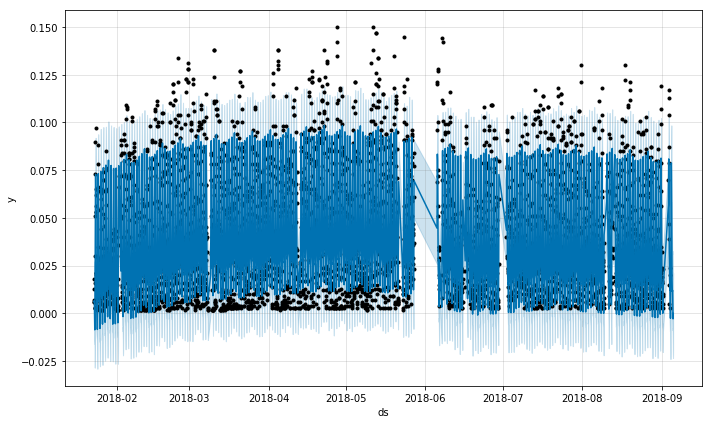

In [66]:
m = Prophet(yearly_seasonality=False).fit(ts_estacion)
future = m.make_future_dataframe(periods=30, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [67]:
errors = fcst.merge(ts_test, on='ds')
errors['RAE'] = abs(errors.y-errors.yhat)/errors.y
print(errors.shape)
errors

(12, 21)


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,y,RAE
0,2018-09-04 04:00:00,0.031641,0.031641,0.031641,-0.008207,0.034401,-0.017858,-0.017858,-0.017858,-0.019273,...,-0.019273,-0.019273,-0.019273,-0.019273,-0.001415,-0.001415,-0.001415,0.012368,0.017,0.272480
1,2018-09-04 05:00:00,0.031636,0.031636,0.031636,-0.011851,0.030306,-0.020441,-0.020441,-0.020441,-0.021931,...,-0.021931,-0.021931,-0.021931,-0.021931,-0.001490,-0.001490,-0.001490,0.009705,0.011,0.117718
2,2018-09-04 06:00:00,0.031632,0.031632,0.031632,-0.015304,0.024860,-0.025243,-0.025243,-0.025243,-0.026800,...,-0.026800,-0.026800,-0.026800,-0.026800,-0.001556,-0.001556,-0.001556,0.004832,0.008,0.396003
3,2018-09-04 07:00:00,0.031627,0.031627,0.031627,-0.019568,0.021191,-0.030256,-0.030256,-0.030256,-0.031870,...,-0.031870,-0.031870,-0.031870,-0.031870,-0.001614,-0.001614,-0.001614,-0.000243,0.005,1.048561
4,2018-09-04 08:00:00,0.031623,0.031623,0.031623,-0.023930,0.017582,-0.032532,-0.032532,-0.032532,-0.034196,...,-0.034196,-0.034196,-0.034196,-0.034196,-0.001664,-0.001664,-0.001664,-0.002573,0.003,1.857554
5,2018-09-04 09:00:00,0.031619,0.031619,0.031619,-0.020296,0.021010,-0.029730,-0.029730,-0.029730,-0.031436,...,-0.031436,-0.031436,-0.031436,-0.031436,-0.001706,-0.001706,-0.001706,0.000183,0.006,0.969533
6,2018-09-04 10:00:00,0.031614,0.031614,0.031614,-0.011219,0.028630,-0.021167,-0.021167,-0.021167,-0.022907,...,-0.022907,-0.022907,-0.022907,-0.022907,-0.001741,-0.001741,-0.001741,0.008707,0.016,0.455824
7,2018-09-04 11:00:00,0.031610,0.031610,0.031610,0.001353,0.041358,-0.007847,-0.007847,-0.007847,-0.009616,...,-0.009616,-0.009616,-0.009616,-0.009616,-0.001769,-0.001769,-0.001769,0.021994,0.020,0.099691
8,2018-09-04 12:00:00,0.031606,0.031606,0.031606,0.017256,0.057803,0.008175,0.008175,0.008175,0.006384,...,0.006384,0.006384,0.006384,0.006384,-0.001791,-0.001791,-0.001791,0.037990,0.037,0.026754
9,2018-09-04 13:00:00,0.031601,0.031601,0.031601,0.032937,0.074760,0.024410,0.024410,0.024410,0.022602,...,0.022602,0.022602,0.022602,0.022602,-0.001808,-0.001808,-0.001808,0.054204,0.060,0.096608


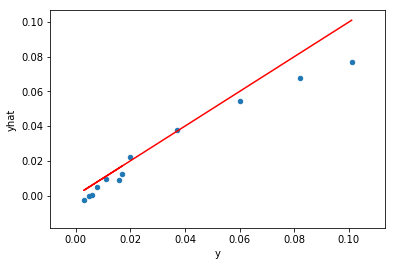

In [68]:
errors.plot.scatter('y', 'yhat')
plt.plot(errors.y, errors.y, color='red')

count    12.000000
mean      0.479282
std       0.547127
min       0.026754
25%       0.113211
50%       0.256114
75%       0.584251
max       1.857554
Name: RAE, dtype: float64

/home/fickincool/anaconda3/envs/opi_py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


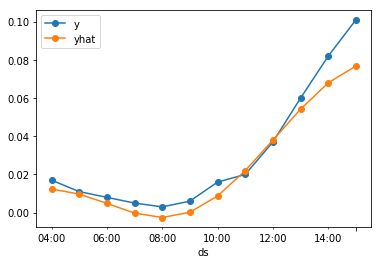

In [69]:
display(errors.RAE.describe())
errors.plot(x='ds', y=['y', 'yhat'], style='-o')

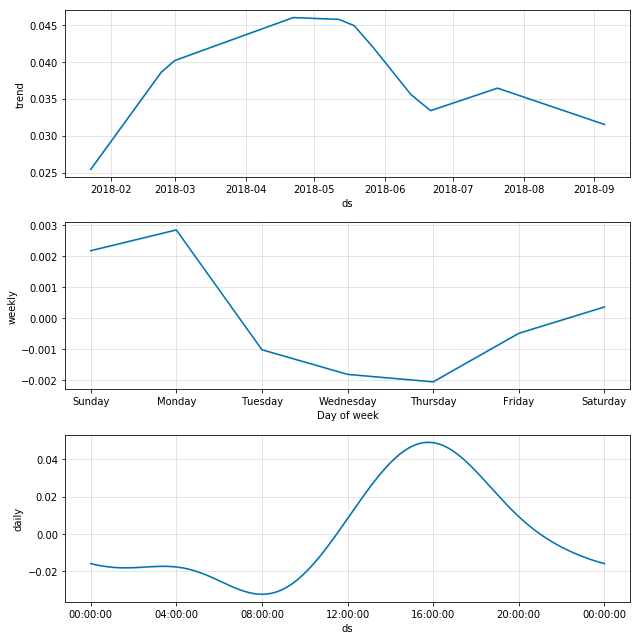

In [70]:
fig = m.plot_components(fcst)